### The purpose of this notebook is to investigate snowfall in Washington, DC. The data set includes daily weather metrics and descriptions from August 2015 - August 2024. 

### Analyses will investigate if days can be classified based on whether any amount of snow fell (as a binary) using other weather metrics.

In [1]:
from IPython.display import Image 
import warnings
warnings.filterwarnings('ignore')
%load_ext rpy2.ipython

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import umap

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
import graphviz

In [2]:
data = pd.read_csv('dc_weather.csv')
data

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Washington,DC,USA",2015-08-01,33.1,22.8,28.2,34.0,22.8,28.6,17.4,53.3,...,22.9,8,NaN,2015-08-01T06:08:52,2015-08-01T20:19:30,0.54,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KIAD,KDCA,72405013743,72403793728,72403093738,..."
1,"Washington,DC,USA",2015-08-02,32.0,22.8,27.3,31.1,22.8,27.2,15.4,49.1,...,22.4,8,NaN,2015-08-02T06:09:44,2015-08-02T20:18:29,0.58,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KIAD,KDCA,72405013743,72403793728,72403093738,..."
2,"Washington,DC,USA",2015-08-03,33.2,21.8,27.9,34.9,21.8,28.7,18.6,58.7,...,24.1,9,NaN,2015-08-03T06:10:38,2015-08-03T20:17:26,0.61,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDCA,72405013743,72403793728,KADW,KDAA,7459401..."
3,"Washington,DC,USA",2015-08-04,35.3,24.9,29.3,36.6,24.9,30.4,19.0,55.2,...,21.9,9,NaN,2015-08-04T06:11:31,2015-08-04T20:16:22,0.65,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"KDCA,72405013743,72403793728,KADW,KDAA,7459401..."
4,"Washington,DC,USA",2015-08-05,33.6,24.0,28.6,33.0,24.0,28.6,17.6,55.3,...,23.7,9,NaN,2015-08-05T06:12:24,2015-08-05T20:15:16,0.68,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,"KDCA,72405013743,72403793728,KGAI,KADW,KDAA,72..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3314,"Washington,DC,USA",2024-08-27,33.3,22.5,27.7,33.7,22.5,27.9,18.9,62.4,...,18.1,8,10.0,2024-08-27T06:33:04,2024-08-27T19:45:18,0.78,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDCA,72405013743,D6279,72403793728,KGAI,KADW,K..."
3315,"Washington,DC,USA",2024-08-28,37.8,24.2,30.2,39.7,24.2,31.9,20.4,58.7,...,16.9,7,10.0,2024-08-28T06:33:58,2024-08-28T19:43:49,0.81,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDCA,72405013743,D6279,72403793728,KADW,KDAA,7..."
3316,"Washington,DC,USA",2024-08-29,32.8,23.3,28.1,38.1,23.3,30.3,21.9,69.7,...,11.5,8,60.0,2024-08-29T06:34:52,2024-08-29T19:42:19,0.85,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"KDCA,72405013743,D6279,72403793728,KGAI,KADW,K..."
3317,"Washington,DC,USA",2024-08-30,23.8,22.2,22.9,23.8,22.2,22.9,20.8,87.6,...,3.4,2,10.0,2024-08-30T06:35:45,2024-08-30T19:40:48,0.88,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"KDCA,72405013743,D6279,72403793728,KGAI,KADW,K..."


### Description of variables

![title](variables.png)

#### Variable of interest here is "snow," which tells us the amount of snow that falls or was predicted to fall. Adding a column, 'AnySnow', which will be a binary variable of whether there any amount of snow falls (1) or no snow falls (0).

#### Adding columns for year, month, and day. 

#### Also adding a column to indicate the "winter" a data point is apart of (so that December 2023 and January 2024, for example, can be analyzed as part of the same winter). This will not be used in the current analyses, but will be used in future analyses investigating changes in snow fall in successive winters. 
    This column will be titled "newYear", indicating the new year that occurred during a given winter. 
    
    So that all data points have a value for newYear, the cutoff will be July. For example, July 2023-June 2024 will have newYear value of 2024.

In [3]:
# creating year, month, day columns 

datestring = data.datetime.unique()

year=[]
month=[]
day=[]

for date in datestring:
    
    y = date[:4]
    m = date[5:7]
    d = date[8:]
    
    year.append([y])
    month.append([m])
    day.append([d])
    
year = pd.DataFrame(year,columns=['year'])
month = pd.DataFrame(month,columns=['month'])
day = pd.DataFrame(day,columns=['day'])

data=pd.concat([data,year,month,day],axis=1)

In [4]:
# add a column where snowfall is > 0 

AnySnow = []

for i in range (len(data)):
    
    if data.snow[i] > 0:
        snowFall = 1
    else: snowFall = 0
    
    AnySnow.append([snowFall])
    
AnySnow = pd.DataFrame(AnySnow, columns=['AnySnow'])
data=pd.concat([data,AnySnow],axis=1)   

In [5]:
data.month = (data.month).astype(float)
data.year = (data.year).astype(float)

winter=[]
for i,y in enumerate(data.year):
        
    if (data.month[i]<7):
        wint = y
        winter.append(wint)
        
    else: 
        wint = y+1
        winter.append(wint)
    
    
            
    newYear = pd.DataFrame(winter,columns=['newYear'])

In [6]:
data=pd.concat([data,newYear],axis=1)
data.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,moonphase,conditions,description,icon,stations,year,month,day,AnySnow,newYear
0,"Washington,DC,USA",2015-08-01,33.1,22.8,28.2,34.0,22.8,28.6,17.4,53.3,...,0.54,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KIAD,KDCA,72405013743,72403793728,72403093738,...",2015.0,8.0,01,0,2016.0
1,"Washington,DC,USA",2015-08-02,32.0,22.8,27.3,31.1,22.8,27.2,15.4,49.1,...,0.58,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KIAD,KDCA,72405013743,72403793728,72403093738,...",2015.0,8.0,02,0,2016.0
2,"Washington,DC,USA",2015-08-03,33.2,21.8,27.9,34.9,21.8,28.7,18.6,58.7,...,0.61,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDCA,72405013743,72403793728,KADW,KDAA,7459401...",2015.0,8.0,03,0,2016.0
3,"Washington,DC,USA",2015-08-04,35.3,24.9,29.3,36.6,24.9,30.4,19.0,55.2,...,0.65,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"KDCA,72405013743,72403793728,KADW,KDAA,7459401...",2015.0,8.0,04,0,2016.0
4,"Washington,DC,USA",2015-08-05,33.6,24.0,28.6,33.0,24.0,28.6,17.6,55.3,...,0.68,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,"KDCA,72405013743,72403793728,KGAI,KADW,KDAA,72...",2015.0,8.0,05,0,2016.0


### Visualize data:

Text(0.5, 0, '')

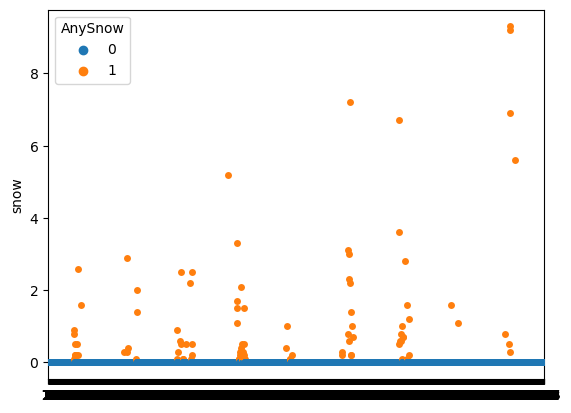

In [7]:
sns.stripplot(x=data.index, y=data.snow, hue=data['AnySnow'])
plt.xlabel('')

### Visualizing snow winter by winter:

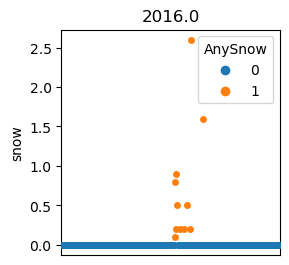

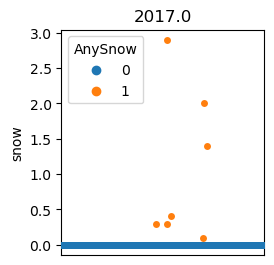

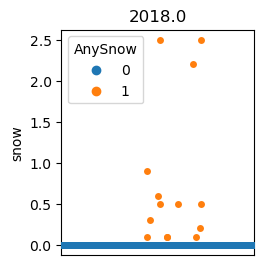

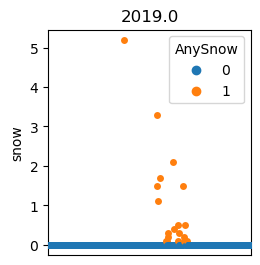

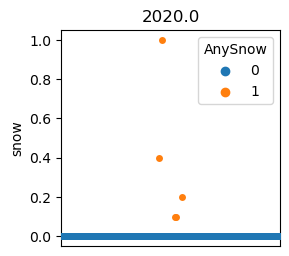

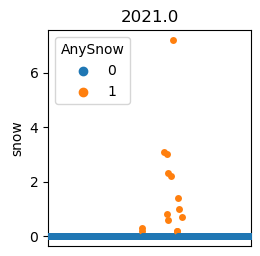

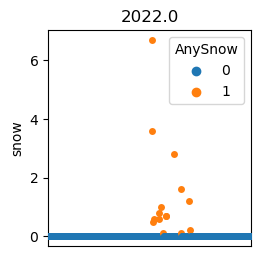

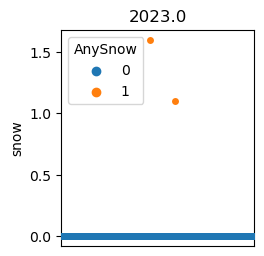

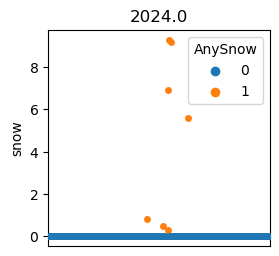

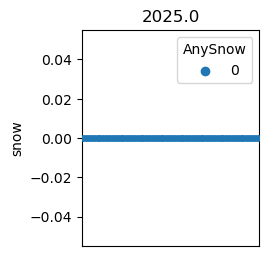

In [8]:
newYear = data.newYear.unique()
for i,y in enumerate(newYear):
    plt.figure(figsize=(10,10))
    plt.subplot(4,4,i+1)
    sns.stripplot(x=data.index[data.newYear==y], y=data.snow[data.newYear==y], hue=data['AnySnow'][data.newYear==y])
    plt.xlabel('')
    plt.xticks([])
    plt.title(y)
    plt.tight_layout()

In [9]:
len(data[data.AnySnow==1]) # snow

94

In [10]:
len(data[data.AnySnow==0]) # no snow

3225

#### This data set is EXTREMELY unbalanced (94 days with snow, 3,225 without). 

#### As a first pass, because the data is so unbalanced, we will try an unsupervised method to see if there are any inherent relationships between the variables.
##### This data set also has variables that are likely highly correlated (e.g. temp and tempmax). We will try PCA first to account for multicollinearity and to reduce the number of features so that maybe we can visualize days with and without snow more clearly than the plots above.

##### Only including numeric variables for PCA:

In [11]:
data_pca = data[['tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover','snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex','moonphase','AnySnow']]

In [12]:
data_pca.corr()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,AnySnow
tempmax,1.000000,0.940168,0.982526,0.992413,0.942842,0.980997,0.904933,0.184334,0.012904,0.008523,...,-0.149606,-0.079774,-0.306538,-0.078761,0.196612,0.448724,0.448228,0.478738,-0.005443,-0.287912
tempmin,0.940168,1.000000,0.983464,0.939570,0.994499,0.978927,0.954152,0.317063,0.094974,0.123495,...,-0.159229,-0.130617,-0.342406,0.093095,0.089409,0.320034,0.319450,0.331881,-0.009826,-0.254449
temp,0.982526,0.983464,1.000000,0.977479,0.982399,0.996619,0.940691,0.241307,0.048295,0.056934,...,-0.156159,-0.101520,-0.328540,-0.000451,0.151052,0.396731,0.396190,0.415889,-0.008406,-0.279517
feelslikemax,0.992413,0.939570,0.977479,1.000000,0.941725,0.981984,0.913461,0.219051,0.029187,0.031444,...,-0.158179,-0.093074,-0.305999,-0.056070,0.183113,0.422566,0.422050,0.453630,-0.004288,-0.291751
feelslikemin,0.942842,0.994499,0.982399,0.941725,1.000000,0.982965,0.957151,0.330550,0.087016,0.110772,...,-0.198666,-0.150159,-0.329846,0.091473,0.088676,0.318776,0.318309,0.330034,-0.010656,-0.271745
feelslike,0.980997,0.978927,0.996619,0.981984,0.982965,1.000000,0.944948,0.262689,0.048329,0.057101,...,-0.182767,-0.119341,-0.321453,0.007383,0.144217,0.384611,0.384112,0.403430,-0.008650,-0.292085
dew,0.904933,0.954152,0.940691,0.913461,0.957151,0.944948,1.000000,0.552676,0.176728,0.221374,...,-0.224338,-0.217980,-0.354848,0.198481,-0.041886,0.195939,0.195339,0.195684,-0.008310,-0.221506
humidity,0.184334,0.317063,0.241307,0.219051,0.330550,0.262689,0.552676,1.000000,0.411088,0.512438,...,-0.253389,-0.374812,-0.227042,0.569046,-0.550320,-0.406297,-0.406717,-0.461637,-0.007520,0.059005
precip,0.012904,0.094974,0.048295,0.029187,0.087016,0.048329,0.176728,0.411088,1.000000,0.439765,...,0.139820,-0.160872,-0.210437,0.324759,-0.488251,-0.270923,-0.271645,-0.299538,-0.016729,0.076425
precipprob,0.008523,0.123495,0.056934,0.031444,0.110772,0.057101,0.221374,0.512438,0.439765,1.000000,...,0.172108,-0.087330,-0.352995,0.475783,-0.404762,-0.309841,-0.309894,-0.332926,-0.017681,0.138302


In [13]:
data.corr()['AnySnow']

tempmax            -0.287912
tempmin            -0.254449
temp               -0.279517
feelslikemax       -0.291751
feelslikemin       -0.271745
feelslike          -0.292085
dew                -0.221506
humidity            0.059005
precip              0.076425
precipprob          0.138302
precipcover         0.217019
snow                0.573744
snowdepth           0.419093
windgust            0.043347
windspeed           0.064580
winddir             0.030473
sealevelpressure    0.044626
cloudcover          0.101816
visibility         -0.274103
solarradiation     -0.144038
solarenergy        -0.144110
uvindex            -0.156133
severerisk         -0.059664
moonphase           0.000413
year               -0.007201
month              -0.175162
AnySnow             1.000000
newYear            -0.031988
Name: AnySnow, dtype: float64

#### We can see above that some variables (e.g. any variable related to the temperature) are very strongly correlated. 

#### 'AnySnow' seems to have strong correlations (unsurprisingly) to variables that pertain to snow ('snow' and 'snowdepth'). 

#### For variables that do not directly pertain to snow, it seems the strongest correlations are with variables related to temperature (strongest is feelslike, -0.292). It also has a somewhat stronger correlation to visibility (-0.274) relative to the other variables.

# PCA:

<Axes: xlabel='pc1', ylabel='pc2'>

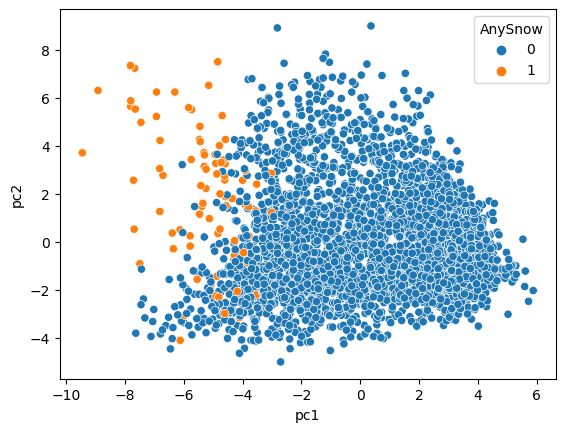

In [14]:
x = data_pca.loc[:,data_pca.columns!='AnySnow'].values
x = StandardScaler().fit_transform(x)
y = data_pca['AnySnow'].values

pca_binary = PCA(n_components=23) 

principalComponents = pca_binary.fit_transform(x)

pcDF = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2','pc3', 'pc4','pc5', 'pc6','pc7', 'pc8','pc9', 'pc10',
                         'pc11', 'pc12','pc13', 'pc14','pc15', 'pc16','pc17', 'pc18','pc19', 'pc20',
                         'pc21', 'pc22','pc23'])

PCA_data = pd.concat([pcDF, data[['AnySnow']]], axis = 1)

sns.scatterplot(data=PCA_data, x='pc1', y='pc2', hue='AnySnow')

In [15]:
pca_binary.explained_variance_ratio_

array([3.36775520e-01, 2.20659365e-01, 1.07906818e-01, 6.59089727e-02,
       4.94550836e-02, 4.30156507e-02, 3.05072342e-02, 2.92808026e-02,
       2.25885170e-02, 2.07410532e-02, 1.89645084e-02, 1.78185983e-02,
       1.15290070e-02, 8.63378830e-03, 6.73479853e-03, 5.20248620e-03,
       3.33691205e-03, 3.66035573e-04, 2.53639214e-04, 2.45128172e-04,
       5.15201450e-05, 1.82955196e-05, 6.26563884e-06])

#### The first two principal components seem to explain the majority of the variance in the data (~55%). 

#### When we add a hue based on if there was snow or not, we can see that the data does seem to be somewhat separable along the first PC axis. However, the days that do have snow (in orange) seem to be more scattered about on the left side of the plot, rather than forming a clear cluster in the data.

<StemContainer object of 3 artists>

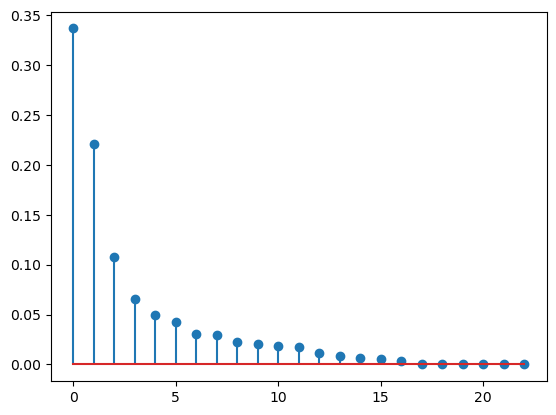

In [16]:
plt.stem(pca_binary.explained_variance_ratio_)

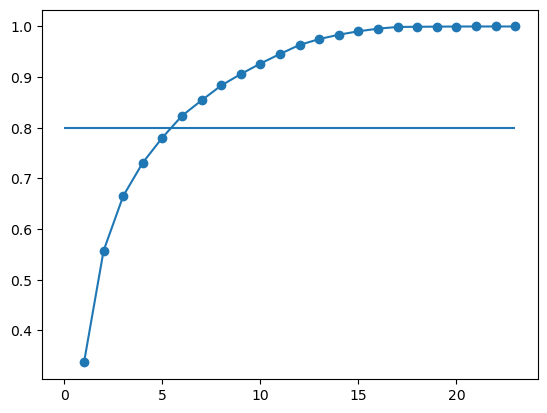

In [17]:
plt.plot(range(1,24),pca_binary.explained_variance_ratio_.cumsum(),marker='o')
plt.hlines(y=0.8,xmin=0,xmax=23)

#### If PCA had been more effective, we would have proceeded with n=6 components, which captures 80% of the variance in the data.
#### Perhaps there isn't separation in the data due to the linearity of PCA. We will next try one more unsupervised method for dimensionality reduction that is non-linear.

# UMAP

In [18]:
reducer = umap.UMAP(n_components=23)
embedding = reducer.fit_transform(data_pca) 

<Axes: >

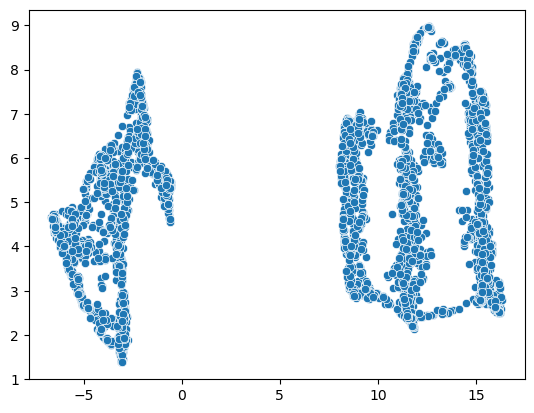

In [19]:
sns.scatterplot(x=embedding.T[0], y=embedding.T[1])

#### UMAP seems to have separated the data. Let's see how if it aligns with AnySnow:

<Axes: >

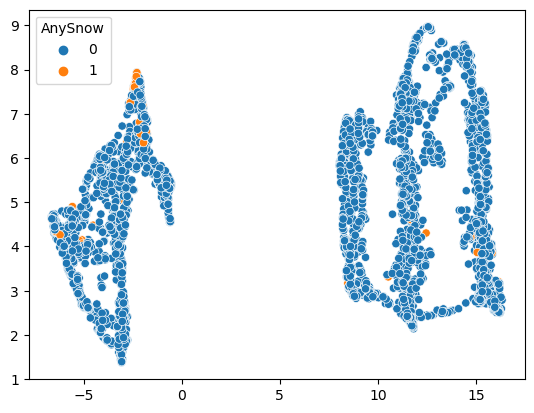

In [20]:
sns.scatterplot(x=embedding.T[0], y=embedding.T[1],hue=data_pca['AnySnow'])

#### It seems as though dimensionality reduction is not appropriate for the question at hand, although it was a good way to explore the data to see if there was any intrinsic separation that might be related to AnySnow. 

#### We will shift to supervised methods.

# Classification tree
    
    Starting with a single decision tree for interpretability, and to get an idea of which features/variables are most important.

### Let's remind ourselves of variables that are most correlated to AnySnow, and also which predictors are correlated to each other:

In [21]:
data_pca.corr()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,AnySnow
tempmax,1.000000,0.940168,0.982526,0.992413,0.942842,0.980997,0.904933,0.184334,0.012904,0.008523,...,-0.149606,-0.079774,-0.306538,-0.078761,0.196612,0.448724,0.448228,0.478738,-0.005443,-0.287912
tempmin,0.940168,1.000000,0.983464,0.939570,0.994499,0.978927,0.954152,0.317063,0.094974,0.123495,...,-0.159229,-0.130617,-0.342406,0.093095,0.089409,0.320034,0.319450,0.331881,-0.009826,-0.254449
temp,0.982526,0.983464,1.000000,0.977479,0.982399,0.996619,0.940691,0.241307,0.048295,0.056934,...,-0.156159,-0.101520,-0.328540,-0.000451,0.151052,0.396731,0.396190,0.415889,-0.008406,-0.279517
feelslikemax,0.992413,0.939570,0.977479,1.000000,0.941725,0.981984,0.913461,0.219051,0.029187,0.031444,...,-0.158179,-0.093074,-0.305999,-0.056070,0.183113,0.422566,0.422050,0.453630,-0.004288,-0.291751
feelslikemin,0.942842,0.994499,0.982399,0.941725,1.000000,0.982965,0.957151,0.330550,0.087016,0.110772,...,-0.198666,-0.150159,-0.329846,0.091473,0.088676,0.318776,0.318309,0.330034,-0.010656,-0.271745
feelslike,0.980997,0.978927,0.996619,0.981984,0.982965,1.000000,0.944948,0.262689,0.048329,0.057101,...,-0.182767,-0.119341,-0.321453,0.007383,0.144217,0.384611,0.384112,0.403430,-0.008650,-0.292085
dew,0.904933,0.954152,0.940691,0.913461,0.957151,0.944948,1.000000,0.552676,0.176728,0.221374,...,-0.224338,-0.217980,-0.354848,0.198481,-0.041886,0.195939,0.195339,0.195684,-0.008310,-0.221506
humidity,0.184334,0.317063,0.241307,0.219051,0.330550,0.262689,0.552676,1.000000,0.411088,0.512438,...,-0.253389,-0.374812,-0.227042,0.569046,-0.550320,-0.406297,-0.406717,-0.461637,-0.007520,0.059005
precip,0.012904,0.094974,0.048295,0.029187,0.087016,0.048329,0.176728,0.411088,1.000000,0.439765,...,0.139820,-0.160872,-0.210437,0.324759,-0.488251,-0.270923,-0.271645,-0.299538,-0.016729,0.076425
precipprob,0.008523,0.123495,0.056934,0.031444,0.110772,0.057101,0.221374,0.512438,0.439765,1.000000,...,0.172108,-0.087330,-0.352995,0.475783,-0.404762,-0.309841,-0.309894,-0.332926,-0.017681,0.138302


In [22]:
data_pca.corr()['AnySnow']

tempmax            -0.287912
tempmin            -0.254449
temp               -0.279517
feelslikemax       -0.291751
feelslikemin       -0.271745
feelslike          -0.292085
dew                -0.221506
humidity            0.059005
precip              0.076425
precipprob          0.138302
precipcover         0.217019
snow                0.573744
snowdepth           0.419093
windgust            0.043347
windspeed           0.064580
winddir             0.030473
sealevelpressure    0.044626
cloudcover          0.101816
visibility         -0.274103
solarradiation     -0.144038
solarenergy        -0.144110
uvindex            -0.156133
moonphase           0.000413
AnySnow             1.000000
Name: AnySnow, dtype: float64

#### To start, let's include: 
* feelslike (the highest correlation to AnySnow of all variables pertaining to temp) 
* precipcover 
* visibility 
* uvindex 

##### These are all of the variables with the highest correlations to AnySnow which have no strong correlations to each other.

#### Because the data is unbalanced, it is important to add class weights when we build our model.

In [23]:
noSnow=len(data_pca)/len(data_pca[data_pca.AnySnow==0]) 
print("weight for no snow:", noSnow) 

weight for no snow: 1.0291472868217055


In [24]:
Snow=len(data_pca)/len(data_pca[data_pca.AnySnow==1]) 
print("weight for snow:", Snow) 

weight for snow: 35.308510638297875


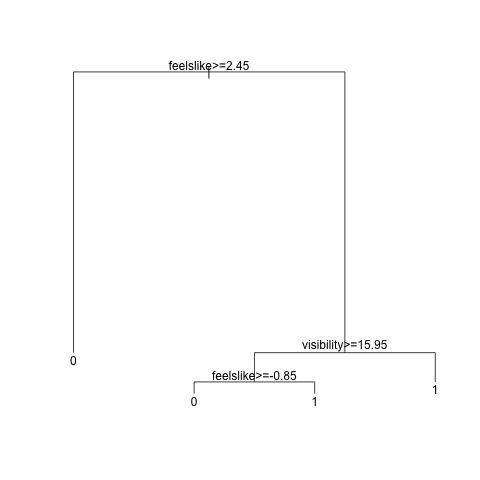

In [25]:
%%R -i data_pca,noSnow,Snow -o data_pca
library(tree)
library(rpart)

data_pca_subset <- subset(data_pca, select = c(AnySnow,feelslike,precipcover,visibility,uvindex))

data_pca_subset$weight <- ifelse(data_pca_subset$AnySnow == 0, noSnow, Snow)

tree <- rpart(as.factor(AnySnow) ~ . -weight, data = data_pca_subset, weights = weight)

plot(tree)
text(tree)

In [26]:
%%R
summary(tree)

Call:
rpart(formula = as.factor(AnySnow) ~ . - weight, data = data_pca_subset, 
    weights = weight)
  n= 3319 

          CP nsplit rel error    xerror        xstd
1 0.84870526      0 1.0000000 1.1400462 0.012152907
2 0.01778163      1 0.1512947 0.1650338 0.006754324
3 0.01000000      3 0.1157315 0.1642718 0.006740112

Variable importance
  feelslike  visibility precipcover     uvindex 
         47          20          16          16 

Node number 1: 3319 observations,    complexity param=0.8487053
  predicted class=1  expected loss=0.5  P(node) =1
    class counts:  3319  3319
   probabilities: 0.500 0.500 
  left son=2 (2843 obs) right son=3 (476 obs)
  Primary splits:
      feelslike   < 2.45   to the right, improve=2409.1080, (0 missing)
      visibility  < 14.85  to the right, improve= 934.7328, (0 missing)
      precipcover < 10.415 to the left,  improve= 757.5028, (0 missing)
      uvindex     < 2.5    to the right, improve= 472.5036, (0 missing)
  Surrogate splits:
      visi

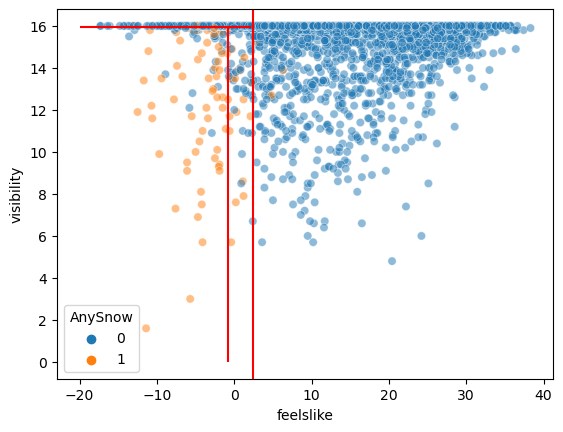

In [27]:
sns.scatterplot(data=data_pca, x='feelslike', y='visibility', hue='AnySnow', alpha=0.5)
plt.axvline(x=2.45,color='red')
plt.hlines(y=15.95,xmin=-20,xmax=2.15,color='red')
plt.vlines(x=-0.85,ymin=0,ymax=16,color='red')

#### This seems as though days with and without snow can be classified pretty well based on these splits.

## Random forest
    Now that we've confirmed a decision tree might be a good route, with variables feelslike and visibility being most important, lets building multiple trees and average them for a model with better prediction.

In [28]:
%%R  
library(randomForest)
set.seed(123)
data_pca_subset <- subset(data_pca, select = c(AnySnow,feelslike,precipcover,visibility,uvindex))
weight <- c(noSnow,Snow)  

rf <- randomForest(as.factor(AnySnow) ~ . , data = data_pca_subset, classwt = weight)
rf


Call:
 randomForest(formula = as.factor(AnySnow) ~ ., data = data_pca_subset,      classwt = weight) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 2.41%
Confusion matrix:
     0  1 class.error
0 3187 38  0.01178295
1   42 52  0.44680851


randomForest 4.7-1.2
Type rfNews() to see new features/changes/bug fixes.
In addition: Warning message:
package ‘randomForest’ was built under R version 4.3.3 


In [29]:
%%R
importance(rf)

            MeanDecreaseGini
feelslike         146.037356
precipcover         4.679654
visibility          8.006952
uvindex            18.956366


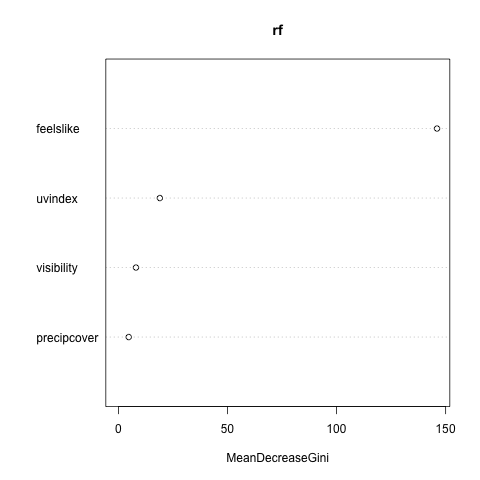

In [30]:
%%R
varImpPlot(rf)

### Split data into training and test to avoid overfitting, then tune model:

In [31]:
X_train, X_test,\
    y_train, y_test = train_test_split(data_pca[['feelslike', 'precipcover', 'visibility', 'uvindex']], 
        data_pca[['AnySnow']],
        random_state=12)

In [32]:
train = pd.concat([X_train,y_train],axis=1)
test = pd.concat([X_test,y_test],axis=1)

In [33]:
%%R -i train
library(randomForest)

set.seed(123)

weight <- c(noSnow,Snow)  

rf_trained <- randomForest(as.factor(AnySnow) ~ . , data = train, classwt = weight)
rf_trained


Call:
 randomForest(formula = as.factor(AnySnow) ~ ., data = train,      classwt = weight) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 2.13%
Confusion matrix:
     0  1 class.error
0 2401 22 0.009079653
1   31 35 0.469696970


### Determine optimal number of trees to include:

In [34]:
%%R
head(rf_trained$err.rate)

            OOB          0         1
[1,] 0.04333333 0.03432494 0.3461538
[2,] 0.04487609 0.03780069 0.3157895
[3,] 0.03850267 0.02748763 0.4313725
[4,] 0.03754753 0.02635432 0.4545455
[5,] 0.03647687 0.02650823 0.4000000
[6,] 0.03751066 0.02673094 0.4218750


In [35]:
%%R -o OOB
OOB <- rf_trained$err.rate[,1]

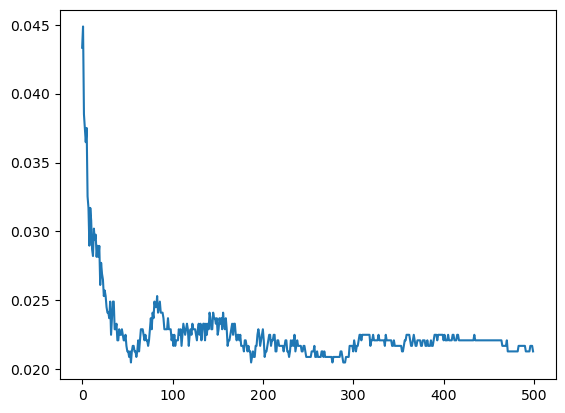

In [36]:
plt.plot(OOB)

In [37]:
np.argmin(OOB)

54

In [38]:
OOB[54]

0.020490156689433506

#### The optimal number of trees is 54.

#### Now let's determine how many variables should be considered at each split.
#### Since we only have 4 features, it will be easy to determine the optimal variables to test at each split by hand instad of using tuneRF().

In [39]:
%%R  
library(randomForest)
set.seed(123)
data_pca_subset <- subset(data_pca, select = c(AnySnow,feelslike,precipcover,visibility,uvindex))
weight <- c(noSnow,Snow)  

rf_1 <- randomForest(as.factor(AnySnow) ~ . , data = train, classwt = weight,mtry=1,ntree=54)
rf_1


Call:
 randomForest(formula = as.factor(AnySnow) ~ ., data = train,      classwt = weight, mtry = 1, ntree = 54) 
               Type of random forest: classification
                     Number of trees: 54
No. of variables tried at each split: 1

        OOB estimate of  error rate: 5.22%
Confusion matrix:
     0   1 class.error
0 2314 109  0.04498556
1   21  45  0.31818182


In [40]:
%%R 
library(randomForest)
set.seed(123)
data_pca_subset <- subset(data_pca, select = c(AnySnow,feelslike,precipcover,visibility,uvindex))
weight <- c(noSnow,Snow)  

rf_2 <- randomForest(as.factor(AnySnow) ~ . , data = train, classwt = weight,mtry=2,ntree=54)
rf_2


Call:
 randomForest(formula = as.factor(AnySnow) ~ ., data = train,      classwt = weight, mtry = 2, ntree = 54) 
               Type of random forest: classification
                     Number of trees: 54
No. of variables tried at each split: 2

        OOB estimate of  error rate: 2.13%
Confusion matrix:
     0  1 class.error
0 2399 24 0.009905076
1   29 37 0.439393939


In [41]:
%%R  
library(randomForest)
set.seed(123)
data_pca_subset <- subset(data_pca, select = c(AnySnow,feelslike,precipcover,visibility,uvindex))
weight <- c(noSnow,Snow)  

rf_3 <- randomForest(as.factor(AnySnow) ~ . , data = train, classwt = weight,mtry=3,ntree=54)
rf_3


Call:
 randomForest(formula = as.factor(AnySnow) ~ ., data = train,      classwt = weight, mtry = 3, ntree = 54) 
               Type of random forest: classification
                     Number of trees: 54
No. of variables tried at each split: 3

        OOB estimate of  error rate: 1.97%
Confusion matrix:
     0  1 class.error
0 2405 18 0.007428807
1   31 35 0.469696970


In [42]:
%%R  
library(randomForest)
set.seed(123)
data_pca_subset <- subset(data_pca, select = c(AnySnow,feelslike,precipcover,visibility,uvindex))
weight <- c(noSnow,Snow)  

rf_4 <- randomForest(as.factor(AnySnow) ~ . , data =train, classwt = weight,mtry=4,ntree=54)
rf_4


Call:
 randomForest(formula = as.factor(AnySnow) ~ ., data = train,      classwt = weight, mtry = 4, ntree = 54) 
               Type of random forest: classification
                     Number of trees: 54
No. of variables tried at each split: 4

        OOB estimate of  error rate: 2.13%
Confusion matrix:
     0  1 class.error
0 2405 18 0.007428807
1   35 31 0.530303030


#### Based on OOB, it seems as though 3 variables at each split is the most effective here (1.97% OOB).
#### Also, we can see looking at the values in the confusion matrix that mtry=3 seems to have the greatest values, and best balance, for precision and recall for days with snow (AnySnow=1). 

### Let's add the number of trees and variables to consider at each split:

In [43]:
%%R -i train
library(randomForest)

set.seed(123)

weight <- c(noSnow,Snow)  

rf_tuned <- randomForest(as.factor(AnySnow) ~ . , data = train, classwt = weight, mtry=3, ntree=54)
rf_tuned


Call:
 randomForest(formula = as.factor(AnySnow) ~ ., data = train,      classwt = weight, mtry = 3, ntree = 54) 
               Type of random forest: classification
                     Number of trees: 54
No. of variables tried at each split: 3

        OOB estimate of  error rate: 1.97%
Confusion matrix:
     0  1 class.error
0 2405 18 0.007428807
1   31 35 0.469696970


In [44]:
%%R -i test

Yhat <- predict(rf_tuned, newdata = test)

table(Predicted=Yhat, Actual=test$AnySnow)

         Actual
Predicted   0   1
        0 795  15
        1   7  13


In [45]:
%%R
mean(Yhat != test$AnySnow) 

[1] 0.02650602


#### *OOB of training model* (still the same model): 1.97%

#### *Overall error rate:* 0.0265

#### *Precision:*
(how accurate are the predictions of days with snow; when yhat=1): 
##### 13/(13+7) = 0.65 
#### *Recall:* 
(how accurate are the predictions when there is truly snow on a given day; when AnySnow=1): 
##### 13/(13+15) = 0.4642

### Since snow days are relatively rare in Washington DC, we want to improve the recall, so that we miss less of the actual snow days (in other words: want to try to reduce the number of false negatives)

### Let's try tuning the decision threshold to see if this helps. We want a balance between precision and recall, so we need to make sure we don't sacrifice *too* much precision to improve recall.

In [46]:
y_test_arr = np.asarray(y_test).ravel()

In [47]:
%%R -i y_test_arr -o recall,precision,thresholds

thresholds <- seq(0, 0.99, by = 0.01) # testing thresholds in incremements of 1%; not going all the way to 100% because all predictions are 0, no snow

Yhat <- predict(rf_tuned, newdata = test, type='prob') # raw probabilities rather than classifying 0 or 1

recall <- numeric(length(thresholds))
precision <- numeric(length(thresholds))

for (i in 1:length(thresholds)) {
  predictions <- ifelse(Yhat[,2] > thresholds[i], 1, 0)  

  conf_matrix <- table(Predicted = predictions, Actual = y_test_arr)
  
  precision[i] <- conf_matrix[2, 2] / (conf_matrix[2, 2] + conf_matrix[2, 1]) # tp / (tp+fp)
  recall[i] <- conf_matrix[2, 2] / (conf_matrix[2, 2] + conf_matrix[1, 2]) # tp / (tp+fn)
}

Loading required package: rlang
In addition: Warning message:
package ‘PRROC’ was built under R version 4.3.3 


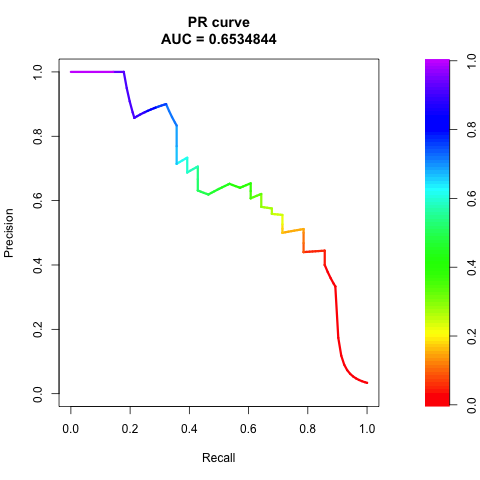

In [48]:
%%R
library(PRROC)
pr <- pr.curve(scores.class0 = Yhat[,2], weights.class0 = y_test_arr, curve = TRUE)
plot(pr)

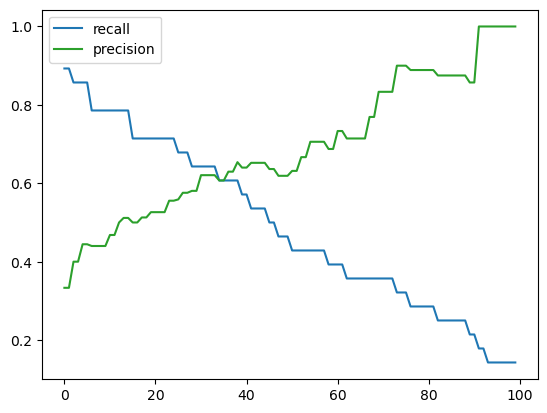

In [49]:
plt.plot(recall, color='C0',label='recall')
plt.plot(precision, color='C2',label='precision')
plt.legend()

In [50]:
for i in range(len(recall)):
    for j in range (len(precision)):
        
        if recall[i] == precision[j]:
            if i == j:
                print(i,j)

34 34
35 35


In [51]:
print(recall[34], recall[35])
print(precision[34], precision[35])

0.6071428571428571 0.6071428571428571
0.6071428571428571 0.6071428571428571


### Let's try a threshold of 0.34, and see how our model does:

In [53]:
%%R 

Yhat <- predict(rf_tuned, newdata = test, type='prob') # raw probabilities rather than classifying 0 or 1

predictions <- ifelse(Yhat[,2] > 0.34, 1, 0)  

conf_matrix <- table(Predicted = predictions, Actual = y_test_arr)

conf_matrix

         Actual
Predicted   0   1
        0 791  11
        1  11  17


In [54]:
%%R
mean(predictions != test$AnySnow) 

[1] 0.02650602


#### *OOB of training model* (still the same model): 1.97%

#### *Overall error rate:* 0.0265

#### *Precision:*
(how accurate are the predictions of days with snow; when yhat=1): 
##### 17/(17+11) = 0.607 *(we already knew this from our plots above)*
#### *Recall:* 
(how accurate are the predictions when there is truly snow on a given day; when AnySnow=1): 
##### 17/(17+11) = 0.607 *(we already knew this from our plots above)*

# CONCLUSIONS

We have built a random forest classifier to try to classify days in DC with and without snow. 

Due to the significant imbalance in the data, we initially explored unsupervised methods to assess whether there was any inherent structure or separation in the data related to snowfall before applying supervised techniques. After confirming there was not, we moved onto tree-based methods.

We first built a single decision tree and visualized the data to assess whether the splits made by the tree effectively separated the different classes.
##### We then built a random forest classifier, and tuned the model in several ways to optimize its prediction accuracy:
* due to the imbalance in data, we added class weights into our model, so that the model would not be biased to the majority class (in this case, days without snow, class 0)
* we determined the optimal number of trees to include based on the minimum OOB
* we determined the optimal number of variables to consider at each split, again based on minimum OOB
* we determined the optimal decision threshold to find the ideal balance between precision and recall

The optimal random forest classifier in this case included 54 trees, considering 3 variables at each split, with a decision threshold of 0.34 (above 0.34 -> classify as 1, snow). Adjusting our threshold resulted in the same overall error rate. The precision decreased ~5%, while the recall increased ~14%. For the purposes of the question at hand, sacrificing some precision for a greater improvement in recall is most beneficial. 

It is also important to keep in mind that in our initial feature selection, no variable (aside from snow and snow depth) was very highly correlated with AnySnow (the greatest correlation to AnySnow was ~-0.29). Although precision and recall of 60% might not seem very high, in our case, this is the best we can do given the data available. 

### Future directions:

##### Currently investigating whether boosting (comparing gbm and xgboost in R) can improve this model further.

##### The split of training and testing data could also be investigated to improve model accuracy. Currently, the training subset is ~75% of the total data. However, the representation of each class is roughly consistent across the subsets of data.

##### Resampling the data may be more effective than simply adjusting the train/test split. We could try a method such as SMOTE, where we can oversample the minority class (AnySnow=1) in our training model. Or, we could undersample the majority (AnySnow=0)